In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
import cv2
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.svm import SVC
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report

In [2]:
seed = 45

In [3]:
data_category = pd.read_csv('info_category.csv', delimiter=';', decimal=".") 
print(data_category.shape)

(493, 4)


In [4]:
def prepare_data(file_name, data_category):
    data = pd.read_csv(file_name+'.csv', delimiter=';', decimal=".") 
    data = data_category.merge(data, left_on=['img_name','folder','image'], right_on=['img_name','folder','image'])
    data[['category']] =  data[['category']].abs()
    data = data[data.category>0]
    data[['category']] =  data[['category']]-1
    return data

In [5]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

file_name = 'info_h_40'
sections_width = int(file_name.split("_")[-1])
data = prepare_data(file_name, data_category)
size_m = sections_width
X_values = data[['h_'+str(a) for a in range(1,size_m+1)]]
y_values = data[['category']]
X_train, X_test, y_train, y_test = train_test_split(X_values, y_values, test_size=0.2, random_state=seed)

#parameters = {'n_neighbors':range(3,7), 'p':[1,2,4]}
parameters = {'C':range(1,10), 'class_weight':['balanced', None]}
svc = SVC(random_state=seed)#KNeighborsClassifier()
clf = GridSearchCV(svc, parameters, scoring='precision_weighted', cv=12)
clf.fit(X_values, y_values.values.ravel())

data = pd.DataFrame(clf.cv_results_)
data.sort_values(by=['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,...,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,mean_test_score,std_test_score,rank_test_score
16,0.003412,0.000489,0.001714,0.000549,9,balanced,"{'C': 9, 'class_weight': 'balanced'}",0.827068,0.789474,0.954887,...,0.909774,1.000000,0.957895,0.847368,0.951389,0.858586,0.850088,0.887127,0.064498,1
14,0.003494,0.000519,0.001857,0.000556,8,balanced,"{'C': 8, 'class_weight': 'balanced'}",0.827068,0.789474,0.954887,...,0.909774,1.000000,0.957895,0.847368,0.951389,0.858586,0.850088,0.885173,0.064752,2
13,0.003417,0.000505,0.001919,0.000507,7,None,"{'C': 7, 'class_weight': None}",0.804511,0.737480,1.000000,...,0.869674,1.000000,1.000000,0.807018,0.951389,0.858586,0.895833,0.883510,0.084516,3
11,0.002944,0.004066,0.000821,0.000886,6,None,"{'C': 6, 'class_weight': None}",0.804511,0.737480,1.000000,...,0.869674,1.000000,1.000000,0.807018,0.951389,0.858586,0.895833,0.883510,0.084516,3
4,0.000000,0.000000,0.003905,0.006764,3,balanced,"{'C': 3, 'class_weight': 'balanced'}",0.827068,0.737480,0.921053,...,0.929825,1.000000,0.957895,0.807018,0.951389,0.858586,0.850088,0.883374,0.070455,5
5,0.003263,0.006069,0.001628,0.004285,3,None,"{'C': 3, 'class_weight': None}",0.804511,0.737480,1.000000,...,0.869674,1.000000,1.000000,0.807018,0.951389,0.858586,0.802469,0.882601,0.084807,6
12,0.004739,0.003349,0.001498,0.000648,7,balanced,"{'C': 7, 'class_weight': 'balanced'}",0.827068,0.789474,0.921053,...,0.909774,1.000000,0.957895,0.847368,0.951389,0.858586,0.850088,0.882354,0.062347,7
1,0.001302,0.004318,0.002604,0.005822,1,None,"{'C': 1, 'class_weight': None}",0.827068,0.673684,0.954887,...,0.929825,1.000000,1.000000,0.807018,0.951389,0.858586,0.802469,0.880418,0.090979,8
7,0.005207,0.007364,0.000000,0.000000,4,None,"{'C': 4, 'class_weight': None}",0.804511,0.737480,1.000000,...,0.869674,1.000000,1.000000,0.807018,0.951389,0.858586,0.850088,0.879698,0.084905,9
17,0.003075,0.000289,0.001742,0.000423,9,None,"{'C': 9, 'class_weight': None}",0.861842,0.673684,1.000000,...,0.869674,1.000000,1.000000,0.807018,0.951389,0.858586,0.845679,0.878792,0.092942,10


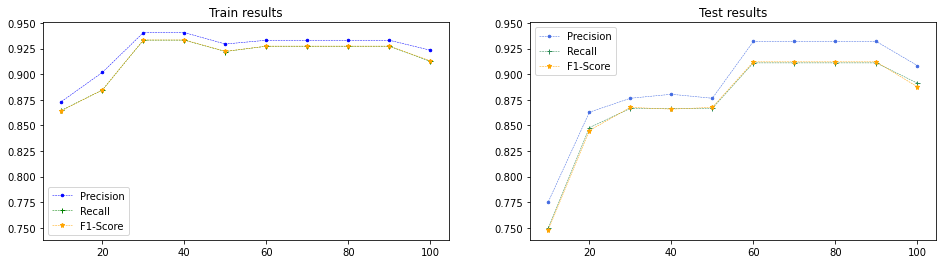

,width,data,precision_train,recall_train,f1_score_train,precision_test,recall_test,f1_score_test
0,60,224,0.933215,0.927374,0.927466,0.932026,0.911111,0.912099
0,70,224,0.933215,0.927374,0.927466,0.932026,0.911111,0.912099
0,80,224,0.933215,0.927374,0.927466,0.932026,0.911111,0.912099
0,90,224,0.933215,0.927374,0.927466,0.932026,0.911111,0.912099
0,100,229,0.923472,0.912568,0.913136,0.908514,0.891304,0.887747
0,30,225,0.940688,0.933333,0.933492,0.876543,0.866667,0.867624
0,50,225,0.929524,0.922222,0.922407,0.876543,0.866667,0.867624
0,40,225,0.940688,0.933333,0.933492,0.880442,0.866667,0.865918
0,20,228,0.901828,0.884615,0.884708,0.862915,0.847826,0.845034
0,10,259,0.873257,0.864734,0.864330,0.775532,0.750000,0.748281


In [6]:
widths = [10,20,30,40,50,60,70,80,90,100]
final_data = pd.DataFrame()
for w in range(0,len(widths)):
    info_results = []    
    file_name = 'info_h_'+str(widths[w])
    sections_width = int(file_name.split("_")[-1])
    data = prepare_data(file_name, data_category)    
    size_m = sections_width
    columns = ['h_'+str(a) for a in range(1,size_m+1)] #+ ['pw_'+str(a) for a in range(1,size_m+1)]
    X_values = data[columns]
    y_values = data[['category']]
    X_train, X_test, y_train, y_test = train_test_split(X_values, y_values, test_size=0.2, random_state=seed)
    kmeans = SVC(C=9, class_weight='balanced', random_state=seed) #KNeighborsClassifier(n_neighbors=6, p=4) #GaussianNB() # 
    kmeans.fit(X_train, y_train.values.ravel())
    y_predict = kmeans.predict(X_train)
    precision_train = (precision_score(y_train, y_predict, average='weighted'))
    recall_train= (recall_score(y_train, y_predict, average='weighted'))
    f1_score_train = f1_score(y_train, y_predict, average='weighted')
    y_predict = kmeans.predict(X_test)
    precision_test = (precision_score(y_test, y_predict, average='weighted'))
    recall_test = (recall_score(y_test, y_predict, average='weighted'))
    f1_score_test = f1_score(y_test, y_predict, average='weighted')
    data_row= [ widths[w], data.shape[0],precision_train, recall_train,precision_test,recall_test, f1_score_train, f1_score_test]
    info_results.append(data_row)
    info_results =pd.DataFrame(info_results, columns=['width','data','precision_train', 'recall_train', 'precision_test','recall_test', 'f1_score_train', 'f1_score_test']) 
    final_data = pd.concat([final_data, info_results])

max_value = final_data[['precision_train', 'recall_train', 'f1_score_train', 'precision_test', 'recall_test', 'f1_score_test']].values.max() + 0.01
min_value = final_data[['precision_train', 'recall_train', 'f1_score_train', 'precision_test', 'recall_test', 'f1_score_test']].values.min() - 0.01

fig, axs = plt.subplots(1,2, figsize=(16,4))
axs[0].title.set_text("Train results")
axs[0].plot(final_data.width,final_data.precision_train,marker='.',linestyle='dashed', color='blue',linewidth=0.5,markersize=5, label='Precision')
axs[0].plot(final_data.width,final_data.recall_train,marker='+',linestyle='dashed',color='green',linewidth=0.5,markersize=5, label='Recall')
axs[0].plot(final_data.width,final_data.f1_score_train,marker='*',linestyle='dashed',color='orange',linewidth=0.5,markersize=5, label='F1-Score')
axs[0].legend()
axs[0].set_ylim([min_value, max_value])

axs[1].title.set_text("Test results")
axs[1].plot(final_data.width,final_data.precision_test,marker='.',linestyle='dashed', color='royalblue',linewidth=0.5,markersize=5, label='Precision')
axs[1].plot(final_data.width,final_data.recall_test,marker='+',linestyle='dashed',color='seagreen',linewidth=0.5,markersize=5, label='Recall')
axs[1].plot(final_data.width,final_data.f1_score_test,marker='*',linestyle='dashed',color='orange',linewidth=0.5,markersize=5, label='F1-Score')
axs[1].legend()
axs[1].set_ylim([min_value, max_value])

plt.show()

final_data = final_data.reindex(['width', 'data','precision_train', 'recall_train', 'f1_score_train', 'precision_test', 'recall_test', 'f1_score_test'], axis=1)
final_data.sort_values(by=['f1_score_test', 'f1_score_train'], ascending=False)

(224, 124)


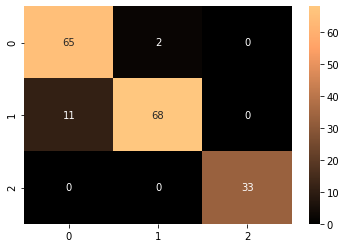

              precision    recall  f1-score   support

           k       0.86      0.97      0.91        67
           s       0.97      0.86      0.91        79
           b       1.00      1.00      1.00        33

    accuracy                           0.93       179
   macro avg       0.94      0.94      0.94       179
weighted avg       0.93      0.93      0.93       179



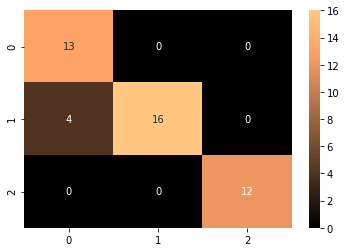

              precision    recall  f1-score   support

           k       0.76      1.00      0.87        13
           s       1.00      0.80      0.89        20
           b       1.00      1.00      1.00        12

    accuracy                           0.91        45
   macro avg       0.92      0.93      0.92        45
weighted avg       0.93      0.91      0.91        45



In [7]:
from sklearn.preprocessing import normalize
file_name = 'info_h_60'
sections_width = int(file_name.split("_")[-1])
data = prepare_data(file_name, data_category)
size_m = sections_width
columns = ['h_'+str(a) for a in range(1,size_m+1)] #+ ['pw_'+str(a) for a in range(1,size_m+1)]
X_values = data[columns]
y_values = data[['category']]
print(data.shape)
X_train, X_test, y_train, y_test = train_test_split(X_values, y_values, test_size=0.2, random_state=seed)
kmeans = SVC(C=9, class_weight='balanced', random_state=seed)#KNeighborsClassifier(n_neighbors=3)#SVC(C=5, class_weight='balanced')#
kmeans.fit(X_train, y_train.values.ravel())
y_predict_train = kmeans.predict(X_train)
precision_train = (precision_score(y_train, y_predict_train, average='weighted'))
recall_train= (recall_score(y_train, y_predict_train, average='weighted'))
y_predict = kmeans.predict(X_test)
precision_test = (precision_score(y_test, y_predict, average='weighted'))
recall_test = (recall_score(y_test, y_predict, average='weighted'))
data_row= [ precision_train, recall_train,precision_test,recall_test]
conf_matrix = confusion_matrix(y_train.values.ravel(),y_predict_train)
sns.heatmap(conf_matrix, annot=True,fmt='d', cmap=plt.cm.copper)
plt.show()
print(classification_report(y_train.values.ravel(),y_predict_train, target_names=['k', 's', 'b']))
conf_matrix = confusion_matrix(y_test.values.ravel(),y_predict)
sns.heatmap(conf_matrix, annot=True,fmt='d', cmap=plt.cm.copper)
plt.show()
print(classification_report(y_test.values.ravel(),y_predict, target_names=['k', 's', 'b']))